# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

In [ ]:
import torch
import torchvision
from torchvision import transforms
import numpy as np

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation.

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set.

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224,224)), #Resnets are optimized for larger input size (the performance highly drops with 32x32 inputs especially for transfer learning with a bigger ResNet)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
#Loading training data
train_set = torchvision.datasets.CIFAR10('/content',train=True,download=True, transform=transform_test)
train_set.data = train_set.data[:100] #Limit to 100 the number of data
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
#Loading testing data
test_set = torchvision.datasets.CIFAR10('/content',train=False,download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

> The network doesn't have access to many samples to train on meaning it will be very likely to overfit the training data and not capture the real dynamics behind data. Moreover with 100 images and 10 classes the number of images per class might have a big variance and balacing batches might be necessary (adding weights in the loss for each class to be equally represented and avoid the network to be biased toward specific classes, using data augmentation).

> To deal with this issue one could either use a regularisation technique (add a prior to the function the network needs to learn, data augmentation, balance batches, ...) or use unlabelled data to get this prior from their distribution (autoencoder with multi tasking, self training, transfer learning, ...). Another idea would be to label data using another method (dictionary learning, gaussian mixture model with handcrafted/learnt features, ...) and to feed them to the neural network to avoid issues with the self loop of self training and provide more stable convergence.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
import matplotlib.pyplot as plt
def trainv2(model,trainloader,testloader,nb_epochs,opt,loss_fn,eval_freq=10):
    #model.train()
    #Define data to be plot
    llosses = []
    ltrain_acc = []
    ltest_acc = []
    for i in range(nb_epochs):
        loss_total = 0
        for batch,lbl in trainloader: #Train epoch
            batch,lbl = batch.to('cuda:0'),lbl.to('cuda:0')
            opt.zero_grad()

            pred = model(batch)
            loss = loss_fn(pred,lbl)

            loss.backward()
            opt.step()

            loss_total += loss.detach()
        llosses.append(loss_total.cpu())
        print('Epoch {}/{} : training loss {}'.format(i,nb_epochs,loss_total.item()))
        if (i+1)%eval_freq == 0: #Print and save accuracies
            train_acc = compute_accuracy(model,trainloader)
            ltrain_acc.append(train_acc)
            test_acc = compute_accuracy(model,testloader)
            ltest_acc.append(test_acc)
            print('Test Accurracy {} | Train Accuracy {}'.format(test_acc,train_acc))
    #Plot scores
    plt.figure()
    plt.plot(range(len(llosses)),llosses,color='red')
    plt.xlabel('nb epochs')
    plt.ylabel('loss')
    plt.title('Loss during training')
    plt.show()

    plt.figure()
    plt.plot(range(0,len(ltrain_acc)*10,10),ltrain_acc,color='red')
    plt.plot(range(0,len(ltest_acc)*10,10),ltest_acc,color="blue")
    plt.xlabel('nb epochs')
    plt.ylabel('accuracy')
    plt.title('Accuracy during training')
    plt.show()
    return ltest_acc

In [ ]:
def compute_accuracy(model,dataloader):
    #model.eval()
    #Computes and return accuracies on the given dataset
    with torch.no_grad():
        acc = []
        for batch,lbl in dataloader:
            batch,lbl = batch.to('cuda:0'),lbl.to('cuda:0')
            pred = model(batch)
            diff = (pred.max(1)[1]==lbl).float()
            acc.append(torch.mean(diff).cpu())
        return np.mean(acc)

In [ ]:
#Define model
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512,10)
model.to('cuda:0')
#Define optimizer / loss
optimizer = torch.optim.SGD(model.parameters(),10**-2,weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,100,gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

Epoch 0/250 : training loss 23.4570255279541
Epoch 1/250 : training loss 22.284908294677734
Epoch 2/250 : training loss 21.505573272705078
Epoch 3/250 : training loss 20.70623779296875
Epoch 4/250 : training loss 20.197998046875
Epoch 5/250 : training loss 19.365205764770508
Epoch 6/250 : training loss 18.321144104003906
Epoch 7/250 : training loss 17.904335021972656
Epoch 8/250 : training loss 16.403156280517578
Epoch 9/250 : training loss 16.53695297241211
Test Accurracy 0.21162109076976776 | Train Accuracy 0.5799999833106995
Epoch 10/250 : training loss 15.179525375366211
Epoch 11/250 : training loss 16.048748016357422
Epoch 12/250 : training loss 14.774147987365723
Epoch 13/250 : training loss 12.526589393615723
Epoch 14/250 : training loss 13.667389869689941
Epoch 15/250 : training loss 10.698007583618164
Epoch 16/250 : training loss 11.285553932189941
Epoch 17/250 : training loss 9.708723068237305
Epoch 18/250 : training loss 9.062039375305176
Epoch 19/250 : training loss 9.91345

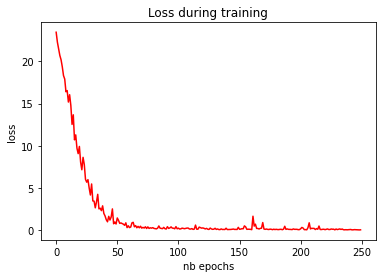

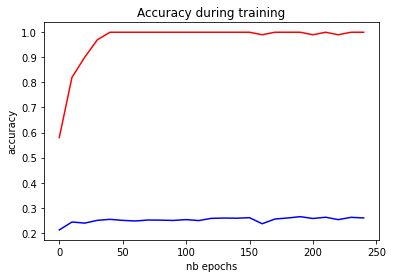

In [ ]:
vanilla_score = trainv2(model,trainloader,testloader,250,optimizer,loss_fn,eval_freq=10)

Results :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Our ResNet18 (100 training set)  | 250 (stable from epoch 100) | 100% | 26% |
|   Given git ResNet18 (100 training set)  | 10 | 40% | 20% |
|   ResNet20 paper (50k training set)  | 64k | ?% | 91% |

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

### Freeze

In [ ]:
#Load pretrained model
model = torchvision.models.resnet152(pretrained=True)
model.train()
model.fc = torch.nn.Linear(2048,10)
model.to('cuda:0')
pass

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
#Freeze all but the last 2 layer
for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.require_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

In [ ]:
#Define new parameters
optimizer = torch.optim.SGD(model.parameters(),10**-2,weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,100,gamma=0.1)

Epoch 0/250 : training loss 24.367734909057617
Epoch 1/250 : training loss 21.08168601989746
Epoch 2/250 : training loss 19.42803955078125
Epoch 3/250 : training loss 16.94935417175293
Epoch 4/250 : training loss 15.376994132995605
Epoch 5/250 : training loss 14.32812213897705
Epoch 6/250 : training loss 12.975504875183105
Epoch 7/250 : training loss 12.106120109558105
Epoch 8/250 : training loss 11.066740989685059
Epoch 9/250 : training loss 9.553641319274902
Test Accurracy 0.44902342557907104 | Train Accuracy 0.8600000143051147
Epoch 10/250 : training loss 9.7661771774292
Epoch 11/250 : training loss 8.999295234680176
Epoch 12/250 : training loss 9.477021217346191
Epoch 13/250 : training loss 8.318942070007324
Epoch 14/250 : training loss 7.384211540222168
Epoch 15/250 : training loss 7.0764665603637695
Epoch 16/250 : training loss 6.673190116882324
Epoch 17/250 : training loss 6.260254859924316
Epoch 18/250 : training loss 5.767268180847168
Epoch 19/250 : training loss 5.80061006546

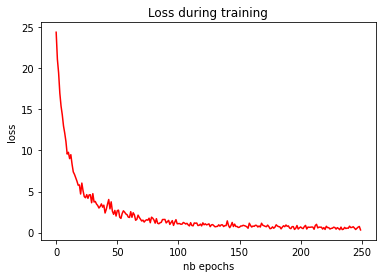

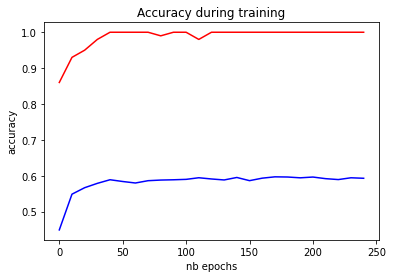

In [ ]:
#Train the new model
frozen_score = trainv2(model,trainloader,testloader,250,optimizer,loss_fn,eval_freq=10)

### Finetuning

In [ ]:
#Load pretrained model
model = torchvision.models.resnet152(pretrained=True)
model.train()
model.fc = torch.nn.Linear(2048,10)
model.to('cuda:0')
pass

In [ ]:
#Unfreeze all layers (useless code - but it can be modified when necessary)
for p in model.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.require_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

In [ ]:
#Define new parameters
optimizer = torch.optim.SGD(model.parameters(),10**-2,weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,100,gamma=0.1)

Epoch 0/250 : training loss 23.375640869140625
Epoch 1/250 : training loss 18.799907684326172
Epoch 2/250 : training loss 14.916059494018555
Epoch 3/250 : training loss 8.901678085327148
Epoch 4/250 : training loss 6.522912979125977
Epoch 5/250 : training loss 4.030010223388672
Epoch 6/250 : training loss 2.6336545944213867
Epoch 7/250 : training loss 1.8845469951629639
Epoch 8/250 : training loss 1.2490655183792114
Epoch 9/250 : training loss 1.4042574167251587
Test Accurracy 0.656542956829071 | Train Accuracy 1.0
Epoch 10/250 : training loss 0.8214842081069946
Epoch 11/250 : training loss 0.4784773886203766
Epoch 12/250 : training loss 0.7927841544151306
Epoch 13/250 : training loss 0.5145734548568726
Epoch 14/250 : training loss 0.5870236754417419
Epoch 15/250 : training loss 0.28208115696907043
Epoch 16/250 : training loss 0.4463632106781006
Epoch 17/250 : training loss 0.41905373334884644
Epoch 18/250 : training loss 0.33296164870262146
Epoch 19/250 : training loss 0.2863536775112

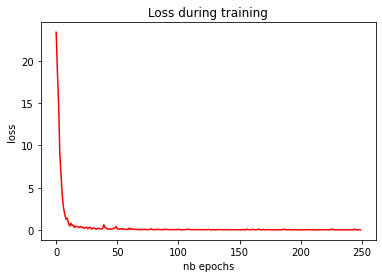

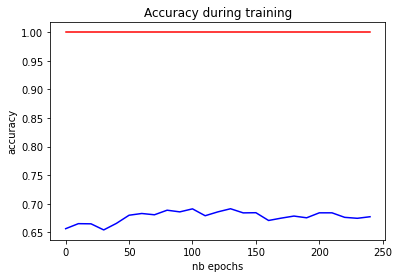

In [ ]:
#Train the new model
finetune_score = trainv2(model,trainloader,testloader,250,optimizer,loss_fn,eval_freq=10)

Results :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Our ResNet18 (100 training set)  | 250 (stable from epoch 50) | 100% | 26% |
|   Our Transfer ResNet152 (Frozen) (100 training set)  | 250 (stable from epoch 50) | 100% | 59% |
|   Our Transfer ResNet152 (Finetune) (100 training set)  | 250 (stable from epoch 10) | 100% | 68% |
|   Given git ResNet18 (100 training set)  | 10 | 40% | 20% |
|   ResNet20 paper (50k training set)  | 64k | ?% | 91% |

# Incorporating priors
Geometrical priors are appealing for image classification tasks.
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.



*   Translations : If you translate the image by a factor a in a direction it means a part of the image will be lost because it will leave the 32x32 support of the image. This part may contain relevant information for the classification especially if a in big (thus the missing part too). In addition what happens on the opposite side ? Do we fill with black pixels (similar to zero padding - not very relevant for classification) ?With pixels lost on the translation direction (similar to same padding - might introduce discontinuities) ? With a mirror of it (similar to mirror padding - probably better but still introduces discontinuities).
*   Rotations : The same issues happen with rotations (loss of information and how to fill missing parts). In addition the question of how the rotation is computed is important as an interpolation function may be needed and interpolating might remove relevant details in the image.
*   Scaling effects : Increasing the scale removes the outer part of the image (maybe with important details). Decreasing the scale is problematic as we would need to fill the image with something.
*   Color changes : In specific images (birds for example) colors might be very important for classification. Changing the color of the image might interfer a lot with the training and features developped by the network. One would thus need to be very carefull about the type of data it is dealing with and only change the invariant properties of color (brightness ? hue ? saturation ?) that don't make the prediction impossible.

In the end data augmentation is a relevant idea to leverage a dataset but we should be careful about invariance we want to give to the network. For instance if we want to train a classifier to estimate at what time of the day a photo was taken the brightness in images might be particularly relanvant so including a random brightness effect in the pipeline might lead to terrible performances.

On the other hand when dealing with particular kind of transformations such as translations, rotations and scaling there is an issue with borders of the image (content removed from the area of the images and missing content).
* For missing content we could pad it with the mean color of the image to avoid creating black borders that could be interpreted as an edge by the convolutions of the network (and lead to undesired behaviors). Another idea would be to do same padding / mirror padding or even to complete the missing parts of the image with the content removed from it by the transformation.
* About the content missing the image we should be careful to not remove important things for the network to be able to classify the image even without a portion of it. In practice it could even be an advantage as it would encourage the network to develop redundant representation and to learn to classify images using as many independant features as possible (see cropping below).


## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html

In [ ]:
#Data augmentation pipeline
crop_size = int(0.8*224) #Random crop size
center_crop_size = int(0.8*224) #Center crop size (to remove most of black borders)
# We don't have very much data so to leverage this small dataset our idea was to focus on small details of those images.
#For example there are several features that could be used to discriminate the bird class (beak, wings, colors, ...).
#Thus feeding crops of images (with only a small part of the original image) to the neural network would encourage it
#to learn redondant representations for each class by learning that several features can be used to classify each class.
#Moreover cropping images is a good way to increase the number of images in the dataset as we could split each image
#in several sub images each with a different feature to encourage redundancy.
data_augment_pipeline = \
{'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(0,scale=(0.8,1.2),translate=(0.2,0.2)), #Scale + Translate (our network should be invariant to those)
    transforms.RandomHorizontalFlip(), #Flip (only horizontal as having horses or birds with the feats upward is weird)
    transforms.ColorJitter( # Change colors. We only changed brightness, contrast and saturation. We wanted to keep colors accurate
            brightness=0.4, #as making the difference between horses and dears with such a low resolution without colors might be hard.
            contrast=0.4,
            saturation=0.4),
    transforms.RandomRotation(degrees=(-20, 20),expand=False), #Only small rotations as most animals don't have the head at 90 degrees
    transforms.CenterCrop((center_crop_size,center_crop_size)), #Centered Crop to reduce the black area created by the rotation
    transforms.Resize((224, 224)),
    transforms.RandomCrop((crop_size,crop_size)), #Randomly crop somewhere in the image to leverage the dataset
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])}

In [ ]:
#Loading training data
train_set = torchvision.datasets.CIFAR10('/content',train=True,download=True, transform=data_augment_pipeline['train'])
train_set.data = train_set.data[:100] #Limit to 100 the number of data
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
#Loading testing data
test_set = torchvision.datasets.CIFAR10('/content',train=False,download=True, transform=data_augment_pipeline['test'])
testloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


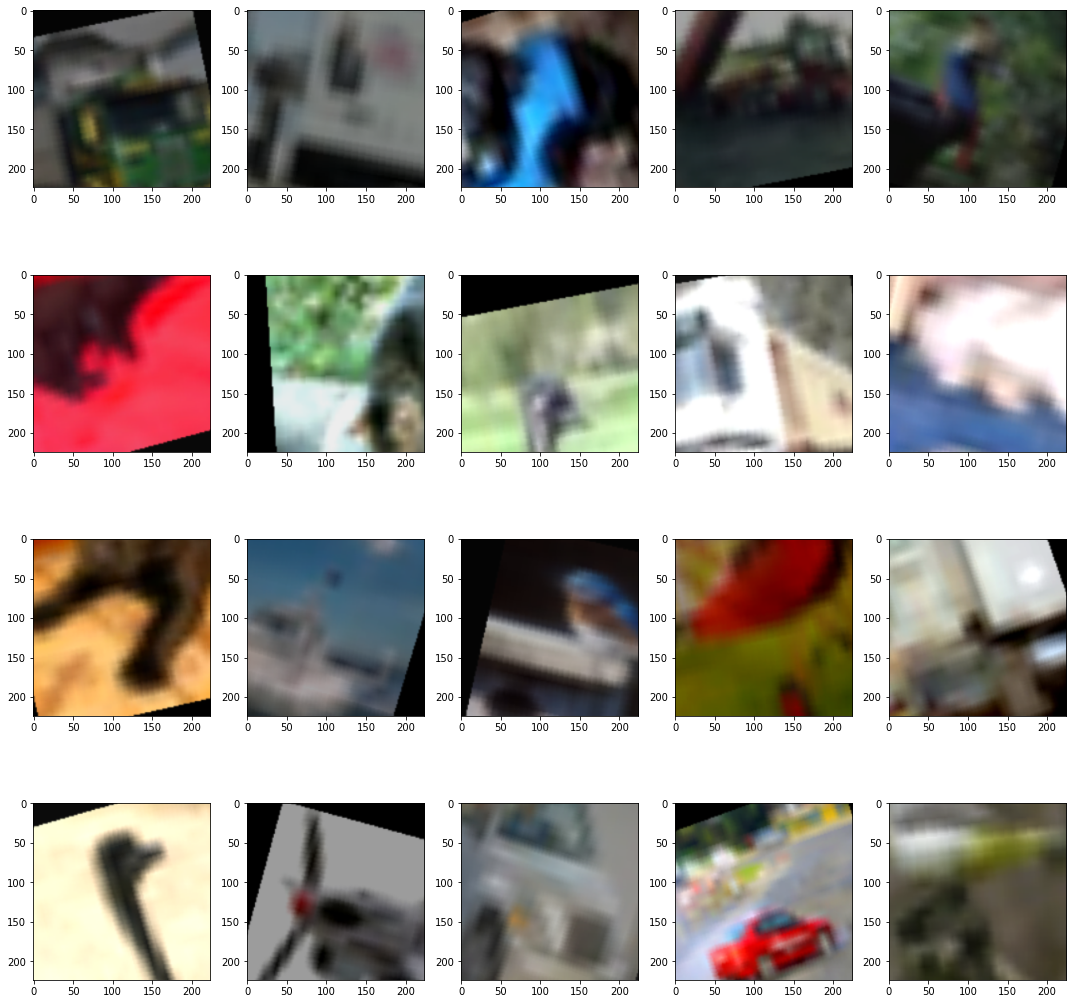

In [ ]:
#Example of data augmented images
import matplotlib.pyplot as plt
std = torch.tensor([0.229, 0.224, 0.225])
mean = torch.tensor([0.485, 0.456, 0.406])
N = 18
plt.figure(figsize=(15,15))
for i,(batch,label) in enumerate(trainloader):
    plt.subplot(4,5,2*i+1)
    plt.imshow(batch[0].permute((1,2,0))*std+mean)
    plt.subplot(4,5,2*i+2)
    plt.imshow(batch[1].permute((1,2,0))*std+mean)
plt.tight_layout()
plt.show()

In [ ]:
#Define model
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512,10)
model.to('cuda:0')
#Define optimizer, scheduler and loss
optimizer = torch.optim.SGD(model.parameters(),10**-2,weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,100,gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

Epoch 0/250 : training loss 24.123558044433594
Epoch 1/250 : training loss 23.60955047607422
Epoch 2/250 : training loss 23.550214767456055
Epoch 3/250 : training loss 23.039077758789062
Epoch 4/250 : training loss 22.91954803466797
Epoch 5/250 : training loss 22.63158416748047
Epoch 6/250 : training loss 21.897302627563477
Epoch 7/250 : training loss 21.53082275390625
Epoch 8/250 : training loss 21.845678329467773
Epoch 9/250 : training loss 21.271656036376953
Test Accurracy 0.16083984076976776 | Train Accuracy 0.22999998927116394
Epoch 10/250 : training loss 21.18370246887207
Epoch 11/250 : training loss 21.36834716796875
Epoch 12/250 : training loss 21.64778709411621
Epoch 13/250 : training loss 20.799774169921875
Epoch 14/250 : training loss 19.631925582885742
Epoch 15/250 : training loss 19.87112808227539
Epoch 16/250 : training loss 19.707603454589844
Epoch 17/250 : training loss 20.16312599182129
Epoch 18/250 : training loss 20.407546997070312
Epoch 19/250 : training loss 19.848

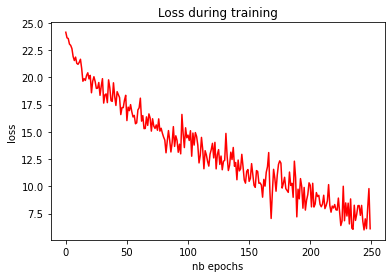

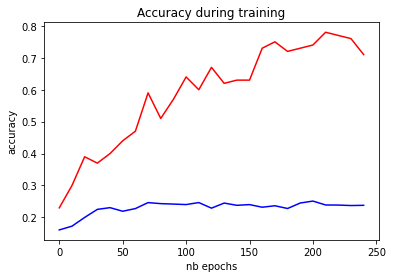

In [ ]:
augmented_score = trainv2(model,trainloader,testloader,250,optimizer,loss_fn,eval_freq=10)

Results :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Our ResNet18 (100 training set)  | 250 (stable from epoch 50) | 100% | 26% |
|   Our Transfer ResNet152 (Frozen) (100 training set)  | 250 (stable from epoch 50) | 100% | 59% |
|   Our Transfer ResNet152 (Finetune) (100 training set)  | 250 (stable from epoch 10) | 100% | 68% |
|   Our DataAugmented ResNet18 (100 training set)  | 250 | 98% | 24% |
|   Given git ResNet18 (100 training set)  | 10 | 40% | 20% |
|   ResNet20 paper (50k training set)  | 64k | ?% | 91% |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

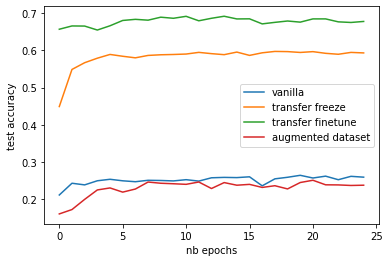

In [ ]:
plt.plot(range(len(vanilla_score)),vanilla_score,color='blue',label='vanilla')
plt.plot(range(len(vanilla_score)),frozen_score,color='red',label='transfer freeze')
plt.plot(range(len(vanilla_score)),finetune_score,color='green',label='transfer finetune')
plt.plot(range(len(vanilla_score)),augmented_score,color='purple',label='augmented dataset')

plt.xlabel('nb epochs')
plt.ylabel('test accuracy')

plt.legend()

plt.title('Comparative plot between the different experiments in this TP')

plt.show()

We trained a resnet18 from scratch in vanilla and data augmentation experiments and a resnet152 pretrained on ImageNet for transfer learning experiments. We saw that most trainings are almost finished after 50 to 100 epochs but we ran them for 250 epochs to see their stability and if the network still learns a little bit after.

* Vanilla Training :
This training only used the 100 labeled data with the whole testing set. The network clearly overfits on the training set as expected even with regularisation techniques (SGD instead of Adam, weight_decay, ...). This training will be used as baseline (blue curve).

* Transfer Learning :
Starting from a resnet152 we tried transfer learning on CIFAR10 only using the 100 first labeled data.
    * A first we froze the first layer and only kept the last fc layer and the layer4 (last convolution layer) unfrozen. This led to 58% acurracy which clearly outperforms the vanilla training (red curve). Freezing layers is an efficient way to do transfer learning as it makes it possible to benefit from representations of a pretrained network without having to compute the gradient over the full network. Nonetheless it is often outperformed by finetuning methods.
    * We then tried finetuning on colab GPUs by unfreezing all layers and reducing the learning rate. This led to slighly better results (68% accuracy). This method is a lot more expensive (training 3 times longer than the previous one). However being able to adapt all the features in previous layers can be quite relevant (and we see it in accuracies - see green curve) but it comes at a computational cost.
    * We also thought about using a different dataset for pretraining (MNIST for example) just to compare how much the knowledge learnt on MNIST is transferable to CIFAR10 compared to IMAGENET (we didn't have enough time to do it).

* Data augmentation :

    * We run the vanilla training with data augmentation. For this pipeline looking at the classes of CIFAR10 we thought about using translations, scaling, rotation, color (only brightness, saturation and contrast because with this low resolution making the difference between horses and deers might be hard with color invariance) and flips.

    * In addition we used crops to leverage the dataset even more (by ensuring redundancy in representations). This led to similar results than the vanilla training (~25%). Pros of data augmentation is that it's a simple method which improves a little bit the results. However it may require a little bit of thinking to decide which are the most relevant invariance and it's not enough to deal with a very small training set as it doesn't make it possible to generate completely new images. For instance if there are only 7 images of birds and the birds class is very diverse in the test set (lots of very different species), the network will never see some bird species in the training set and data augmentation isn't enough to generalise to new species.
    * In our experiment the data augmentation method reaches a better accuracy quicker than the vanilla training but then the accuracy slowly drops and it gets outperformed by the vanilla training (purple curve). This could come from the fact that our data augmentation pipeline is too heavy and the network uses part of its neurons to handle unnecessary invariances which conflicts with the main objective.


In [ ]:
import pandas as pd
from collections import Counter

labels = []
for batch,lbl in trainloader:
    labels += lbl.tolist()
count_labels = pd.DataFrame(Counter(labels), index=[0])
print("number of images per class (upper line : class index || lower line : number of samples for this class")
print(count_labels)

number of images per class (upper line : class index || lower line : number of samples for this class
    9   4   1   3  5  0   2  6   7  8
0  12  11  16  13  7  6  13  7  11  4


Here we see that the number of images per class can vary quite a lot from a class to another (class 8 has 4 samples but class 2 has 13). Thus balancing classes or using a different weight in the loss for each class could help in this scenario.

We also tried weak supervision to go further.

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

### Self supervised Training

We wanted to try self supervised training even if it may not be the best choice here (multitasking with the position task might be better here) because we have seen it in a NLP lecture as well and we wanted to learn more about it.

In [ ]:
#Loading training data
train_set = torchvision.datasets.CIFAR10('/content',train=True,download=True, transform=transform_test)
train_set.data = train_set.data[:100] #Limit to 100 the number of data
train_set.targets = train_set.targets[:100]
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
#Loading training data
unlabeled_train_set = torchvision.datasets.CIFAR10('/content',train=True,download=True, transform=transform_test)
unlabeled_train_set.data = unlabeled_train_set.data[100:100+500] #Limit to 500 the amount of unlabeled data
unlabeled_train_set.targets = unlabeled_train_set.targets[100:100+500]
unlabeled_train_set.targets = [unlabeled_train_set.targets[i]*0-1 for i in range(len(unlabeled_train_set.targets))] #Remove labels
#Loading testing data
test_set = torchvision.datasets.CIFAR10('/content',train=False,download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from PIL import Image
def estimate_labels(model,trainset,batch_size=256):
    """ Updates all the labels in the unlabelled dataset according to predictions from the network """
    #Computes the number of batches
    nb_batch = trainset.data.shape[0]//batch_size
    if (trainset.data.shape[0]//batch_size)*batch_size != trainset.data.shape[0]:
        nb_batch += 1
    for i in range(nb_batch): #Takes all data of the set sequentially
        batch = []
        #Loads a batch
        for j in range(batch_size):
            if i*batch_size+j>=len(trainset.data):
                break
            batch.append(trainset[i*batch_size+j][0][None])
        batch = torch.cat(batch,dim=0).cuda()
        #Computes the prediction
        pred = model(batch)
        classes = pred.max(1)[1]
        #Update targets for this batch
        trainset.targets[i*batch_size:(i+1)*batch_size] = classes.cpu()

In [ ]:
import copy
def self_trainv2(model,trainloader,unlabeled_train_set,testloader,nb_epochs,opt,loss_fn,eval_freq=10,estimate_freq=10,estimate_batch_size=256,estimate_start=80):
    model.train()
    #Define data to be plot
    llosses = []
    ltrain_acc = []
    ltest_acc = []
    #Initialize the trainloader with only the labeled data
    active_trainloader = copy.deepcopy(trainloader)
    for i in range(nb_epochs):
        loss_total = 0
        for batch,lbl in active_trainloader:
            batch,lbl = batch.to('cuda:0'),lbl.to('cuda:0')
            opt.zero_grad()

            pred = model(batch)
            loss = loss_fn(pred,lbl)

            loss.backward()
            opt.step()

            loss_total += loss.detach()
        llosses.append(loss_total.cpu())
        print('Epoch {}/{} : training loss {}'.format(i,nb_epochs,loss_total.item()))
        if (i+1)%eval_freq == 0: #Print Accuracies
            train_acc = compute_accuracy(model,trainloader)
            ltrain_acc.append(train_acc)
            test_acc = compute_accuracy(model,testloader)
            ltest_acc.append(test_acc)
            print('Test Accurracy {} | Train Accuracy {}'.format(test_acc,train_acc))
        if (i+1)%estimate_freq == 0 and i>=estimate_start: #Estimate new labels
            print('SWITCH')
            estimate_labels(model,unlabeled_train_set,batch_size=estimate_batch_size)
            active_trainloader = torch.utils.data.DataLoader(trainloader.dataset, batch_size=256, shuffle=True)
            active_trainloader.dataset.data = np.concatenate([trainloader.dataset.data,unlabeled_train_set.data],axis=0)
            active_trainloader.dataset.targets = np.concatenate([trainloader.dataset.targets,unlabeled_train_set.targets],axis=0)

    #Plot results after training
    plt.figure()
    plt.plot(range(len(llosses)),llosses,color='red')
    plt.xlabel('nb epochs')
    plt.ylabel('loss')
    plt.title('Loss during training')
    plt.show()

    plt.figure()
    plt.plot(range(0,len(ltrain_acc)*10,10),ltrain_acc,color='red')
    plt.plot(range(0,len(ltest_acc)*10,10),ltest_acc,color="blue")
    plt.xlabel('nb epochs')
    plt.ylabel('accuracy')
    plt.title('Accuracy during training')
    plt.show()

In [ ]:
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512,10)
model.to('cuda:0')
optimizer = torch.optim.SGD(model.parameters(),10**-2,weight_decay=5e-4)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,50,gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=100,min_lr=10**-4,verbose=True)
loss_fn = torch.nn.CrossEntropyLoss()

Epoch 0/250 : training loss 23.390470504760742
Epoch 1/250 : training loss 22.42372703552246
Epoch 2/250 : training loss 21.582674026489258
Epoch 3/250 : training loss 20.60139274597168
Epoch 4/250 : training loss 21.254352569580078
Epoch 5/250 : training loss 19.447877883911133
Epoch 6/250 : training loss 18.824535369873047
Epoch 7/250 : training loss 18.10466766357422
Epoch 8/250 : training loss 17.019805908203125
Epoch 9/250 : training loss 16.696849822998047
Test Accurracy 0.20087890326976776 | Train Accuracy 0.5699999928474426
Epoch 10/250 : training loss 15.783841133117676
Epoch 11/250 : training loss 14.307877540588379
Epoch 12/250 : training loss 14.275073051452637
Epoch 13/250 : training loss 13.96354866027832
Epoch 14/250 : training loss 13.210905075073242
Epoch 15/250 : training loss 12.019621849060059
Epoch 16/250 : training loss 10.5426025390625
Epoch 17/250 : training loss 10.646761894226074
Epoch 18/250 : training loss 11.158628463745117
Epoch 19/250 : training loss 9.40

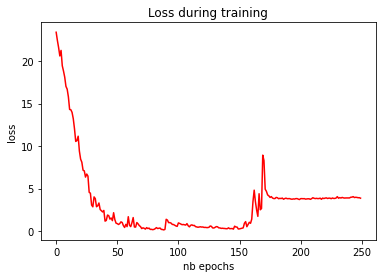

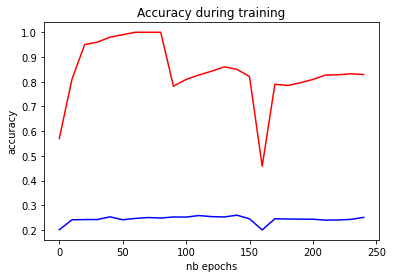

In [ ]:
self_trainv2(model,trainloader,unlabeled_train_set,testloader,250,optimizer,loss_fn,eval_freq=10,estimate_freq=10,estimate_batch_size=256,estimate_start=80)

Results aren't particularly good and have a huge variance. On one hand if there are too many unlabeled samples the algorithm will be biased toward estimated labels creating a very chaotic behavior (and low accuracy on test dataset). We see that in the loss that climbs up before stabilising at the end with a worse performance. This is due to a changing in the labels of the unlabeled dataset that brings an inertia and degrades the performance.

On the other hand if there are too little additional data there is no point in doing self training. This method could probably be better with more labeled data or by reducing the weight of estimated labels in the loss.

Moreover bias in class balance is very detrimental to self supervision because the under represented classes won't get new images in its class which snowball this imbalance.

Results :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Our ResNet18 (100 training set)  | 250 (stable from epoch 50) | 100% | 26% |
|   Our Transfer ResNet152 (Frozen) (100 training set)  | 250 (stable from epoch 50) | 100% | 59% |
|   Our Transfer ResNet152 (Finetune) (100 training set)  | 250 (stable from epoch 10) | 100% | 68% |
|   Our DataAugmented ResNet18 (100 training set)  | 250  | 98% | 24% |
|   Our Self Supervised ResNet18 (100 training set + 50 unlabelled data)  | 250 (stable from epoch 10) | 86% | 24% |
|   Given git ResNet18 (100 training set)  | 10 | 40% | 20% |
|   ResNet20 paper (50k training set)  | 64k | ?% | 91.25% |